# Kaspi Coffee Inventory Management Project

Интеллектуальная система анализа ассортимента кофе на Kaspi для задач inventory management.

Пайплайн: сбор данных → очистка → feature engineering → классификация популярности → регрессия спроса → сохранение моделей.

1. Сбор данных (скрейпинг Kaspi)
2. Очистка + feature engineering
3. Классификация популярности (is_popular)
4. Регрессия спроса (reviews_count)
5. Тюнинг моделей (GridSearch)
6. Интерпретируемость (feature importance)
7. Inventory-метрики (safety stock, reorder point, топ-листы)


## Project summary

- Dataset: 834 SKU coffee (Kaspi)
- Features: 14
- Classification (tuned RF): ROC-AUC=0.86, PR-AUC=0.76, threshold=0.59
- Regression (tuned RF): RMSE=34.6, R²=0.37
- Inventory Outputs: safety_stock, reorder_point, top-lists
- Final tool: Streamlit dashboard for SKU & portfolio decisions


In [83]:
pip install requests beautifulsoup4 pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
!pip install lightgbm


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
# === Импорты ===

import os
import glob
import re

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

import lightgbm as lgb
import joblib

pd.set_option("display.max_columns", 100)


In [86]:
# === Шаг 1. Функция парсинга одной HTML-страницы Kaspi ===

def parse_kaspi_html_file(path: str) -> pd.DataFrame:
    """
    Читает сохранённый HTML-файл Kaspi и вытаскивает:
    - product_id
    - name
    - price
    - rating (по классу _50 -> 5.0)
    - reviews_count
    """
    with open(path, "r", encoding="utf-8") as f:
        html = f.read()

    soup = BeautifulSoup(html, "html.parser")

    cards = soup.select("div.item-card")
    rows = []

    for card in cards:
        product_id = card.get("data-product-id")

        # Название
        name_tag = card.select_one("a.item-card__name-link")
        name = name_tag.get_text(strip=True) if name_tag else None

        # Цена
        price_tag = card.select_one("div.item-card__debet span.item-card__prices-price")
        if price_tag:
            price_text = price_tag.get_text(strip=True)
            m = re.findall(r"\d+", price_text)
            price = float("".join(m)) if m else None
        else:
            price = None

        # Рейтинг
        rating_span = card.select_one("div.item-card__rating span.rating")
        rating = None
        if rating_span:
            classes = rating_span.get("class", [])
            num = None
            for c in classes:
                if c.startswith("_") and len(c) > 1 and c[1:].isdigit():
                    num = int(c[1:])
                    break
            if num is not None:
                rating = num / 10.0

        # Кол-во отзывов
        reviews_link = card.select_one("div.item-card__rating a")
        reviews_count = None
        if reviews_link:
            text = reviews_link.get_text(strip=True)
            m = re.findall(r"\d+", text)
            if m:
                reviews_count = int(m[0])

        rows.append(
            {
                "product_id": product_id,
                "name": name,
                "price": price,
                "rating": rating,
                "reviews_count": reviews_count,
            }
        )

    return pd.DataFrame(rows)


# Быстрая проверка на одной странице (опционально)
df_test = parse_kaspi_html_file("kaspi_coffee_page_1.html")
display(df_test.head())


,product_id,name,price,rating,reviews_count
0,105058953,Кофе растворимый MacCoffee coffee mix порошков...,89.0,5.0,72
1,100240109,Кофе растворимый MacCoffee Cappuccino Di Torin...,150.0,4.9,98
2,100208035,Кофе растворимый NESCAFE Gold сублимированный ...,2099.0,4.9,58
3,100240184,Кофе растворимый MacCoffee 3 в 1 Карамель поро...,79.0,4.9,26
4,100207925,Кофе растворимый Jacobs Monarch сублимированны...,3245.0,5.0,77


In [87]:
# === Шаг 2. Сбор данных со всех сохранённых страниц ===

def collect_kaspi_local(pattern: str = "kaspi_coffee_page_*.html") -> pd.DataFrame:
    """
    Собирает все HTML-файлы по шаблону и объединяет в один датафрейм.
    """
    files = sorted(glob.glob(pattern))
    print("Нашли файлов:", len(files))
    print("Примеры файлов:", files[:5])

    all_dfs = []
    for path in files:
        print("Парсим файл:", path)
        df_page = parse_kaspi_html_file(path)
        print("  товаров на странице:", len(df_page))
        all_dfs.append(df_page)

    if not all_dfs:
        print("Файлы не найдены или пустые.")
        return pd.DataFrame()

    df_all = pd.concat(all_dfs, ignore_index=True)
    df_all = df_all.drop_duplicates(subset=["product_id", "name", "price"])
    print("Итого уникальных товаров:", len(df_all))
    return df_all


df_all = collect_kaspi_local(pattern="kaspi_coffee_page_*.html")
print("Форма df_all:", df_all.shape)
display(df_all.head())

# Сохраняем «сырые» данные
df_all.to_csv("kaspi_coffee_raw.csv", index=False)
print("Сохранено: kaspi_coffee_raw.csv")


Нашли файлов: 83
Примеры файлов: ['kaspi_coffee_page_1.html', 'kaspi_coffee_page_10.html', 'kaspi_coffee_page_11.html', 'kaspi_coffee_page_12.html', 'kaspi_coffee_page_13.html']
Парсим файл: kaspi_coffee_page_1.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_10.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_11.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_12.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_13.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_14.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_15.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_16.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_17.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_18.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_19.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_2.html
  товаров на странице: 12
Парсим файл: kaspi_coffee_page_20.html
  тов

C:\Users\KNB4\AppData\Local\Temp\ipykernel_11432\508415416.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(all_dfs, ignore_index=True)


Итого уникальных товаров: 834
Форма df_all: (834, 5)


,product_id,name,price,rating,reviews_count
0,105058953,Кофе растворимый MacCoffee coffee mix порошков...,89.0,5.0,72.0
1,100240109,Кофе растворимый MacCoffee Cappuccino Di Torin...,150.0,4.9,98.0
2,100208035,Кофе растворимый NESCAFE Gold сублимированный ...,2099.0,4.9,58.0
3,100240184,Кофе растворимый MacCoffee 3 в 1 Карамель поро...,79.0,4.9,26.0
4,100207925,Кофе растворимый Jacobs Monarch сублимированны...,3245.0,5.0,77.0


Сохранено: kaspi_coffee_raw.csv


In [88]:
# === Шаг 3–4. Очистка и feature engineering ===

df = df_all.copy()

# 1. Базовая очистка
# --------------------

# Заполняем пропуски по рейтингу медианой
if df["rating"].isna().any():
    df["rating"] = df["rating"].fillna(df["rating"].median())

# Пропуски по отзывам → 0
if df["reviews_count"].isna().any():
    df["reviews_count"] = df["reviews_count"].fillna(0)

# Удаляем строки без цены
df = df[df["price"].notnull()].reset_index(drop=True)


# 2. BRAND из name — более умный парсинг
# --------------------------------------

KNOWN_BRANDS = [
    "NESCAFE", "Nescafe", "NESCAFÉ",
    "Jacobs", "JACOBS",
    "MacCoffee", "Maccoffee",
    "Tchibo", "TCHIBO",
    "Lavazza", "LAVAZZA",
    "Davidoff", "DAVIDOFF",
    "Carte Noire", "Carte", "NOIRE",
    "Bushido", "BUSHIDO",
]

def extract_brand(name: str) -> str:
    """
    Пытаемся найти бренд по вхождению в строку.
    Если ни один известный бренд не найден — 'Other'.
    """
    if not isinstance(name, str):
        return "Other"

    lower_name = name.lower()
    for b in KNOWN_BRANDS:
        if b.lower() in lower_name:
            # Берём первое слово бренда (Jacobs, NESCAFE, MacCoffee...)
            return b.split()[0]
    return "Other"

df["brand"] = df["name"].apply(extract_brand)

# Оставляем топ-N брендов (кроме 'Other'), остальные → Other
TOP_N_BRANDS = 7
brand_counts = df["brand"].value_counts()

top_brands = [b for b in brand_counts.index if b != "Other"][:TOP_N_BRANDS]
df["brand_top"] = df["brand"].where(df["brand"].isin(top_brands), "Other")

brand_dummies = pd.get_dummies(df["brand_top"], prefix="brand", drop_first=True)


# 3. SELLER (Продавцы) — если колонка есть
# ----------------------------------------

def first_existing_column(columns, df_cols):
    for c in columns:
        if c in df_cols:
            return c
    return None

seller_col = first_existing_column(
    ["seller", "seller_name", "Продавцы", "Продавец"],
    df.columns
)

if seller_col is not None:
    df["seller_raw"] = (
        df[seller_col]
        .fillna("Unknown")
        .astype(str)
        .str.strip()
    )
    TOP_N_SELLERS = 5
    seller_counts = df["seller_raw"].value_counts()
    top_sellers = [s for s in seller_counts.index if s != "Unknown"][:TOP_N_SELLERS]
    df["seller_top"] = df["seller_raw"].where(df["seller_raw"].isin(top_sellers), "Other")
    seller_dummies = pd.get_dummies(df["seller_top"], prefix="seller", drop_first=True)
else:
    seller_dummies = pd.DataFrame(index=df.index)


# 4. PACKAGING (Упаковка) — если колонка есть
# -------------------------------------------

pack_col = first_existing_column(
    ["packaging", "Упаковка", "package"],
    df.columns
)

if pack_col is not None:
    df["packaging_raw"] = (
        df[pack_col]
        .fillna("Unknown")
        .astype(str)
        .str.strip()
    )
    TOP_N_PACK = 5
    pack_counts = df["packaging_raw"].value_counts()
    top_pack = [p for p in pack_counts.index if p != "Unknown"][:TOP_N_PACK]
    df["packaging_top"] = df["packaging_raw"].where(df["packaging_raw"].isin(top_pack), "Other")
    pack_dummies = pd.get_dummies(df["packaging_top"], prefix="pack", drop_first=True)
else:
    pack_dummies = pd.DataFrame(index=df.index)


# 5. COUNTRY (Страна) — если колонка есть
# ---------------------------------------

country_col = first_existing_column(
    ["country", "Страна"],
    df.columns
)

if country_col is not None:
    df["country_raw"] = (
        df[country_col]
        .fillna("Unknown")
        .astype(str)
        .str.strip()
    )
    TOP_N_COUNTRY = 5
    country_counts = df["country_raw"].value_counts()
    top_countries = [c for c in country_counts.index if c != "Unknown"][:TOP_N_COUNTRY]
    df["country_top"] = df["country_raw"].where(df["country_raw"].isin(top_countries), "Other")
    country_dummies = pd.get_dummies(df["country_top"], prefix="country", drop_first=True)
else:
    country_dummies = pd.DataFrame(index=df.index)


# 6. Вес / объём + цена за 100 г
# ------------------------------

def extract_weight(text):
    if not isinstance(text, str):
        return None
    m = re.search(r"(\d+)\s*(г|гр|g|мл|ml)", text.lower())
    if m:
        return int(m.group(1))
    return None

df["pack_size"] = df["name"].apply(extract_weight)

if df["pack_size"].isna().any():
    df["pack_size"] = df["pack_size"].fillna(df["pack_size"].median())

df["price_per_100g"] = df["price"] / df["pack_size"] * 100


# 7. Дополнительные числовые фичи
# -------------------------------

# цена за грамм/мл
df["price_per_g"] = df["price"] / df["pack_size"]

# взаимодействия (price * rating, rating * pack_size)
df["price_rating"] = df["price"] * df["rating"]
df["rating_pack"] = df["rating"] * df["pack_size"]

# логарифм отзывов — больше для анализа, в моделях сейчас не используем
df["log_reviews"] = np.log1p(df["reviews_count"])


# 8. Собираем финальный датафрейм с фичами
# ----------------------------------------

df = pd.concat(
    [
        df,
        brand_dummies,
        seller_dummies,
        pack_dummies,
        country_dummies,
    ],
    axis=1,
)

# Числовые признаки для моделей
base_numeric_features = [
    "price",
    "rating",
    "pack_size",
    "price_per_100g",
    "price_per_g",
    "price_rating",
    "rating_pack",
]

# Категориальные (dummy) признаки
brand_features = list(brand_dummies.columns)
seller_features = list(seller_dummies.columns)
pack_features = list(pack_dummies.columns)
country_features = list(country_dummies.columns)

# Итоговые списки фич:
# 🔹 КЛАССИФИКАЦИЯ: прогноз is_popular (БЕЗ reviews_count — чтобы не было leakage)
feature_cols_clf = (
    base_numeric_features
    + brand_features
    + seller_features
    + pack_features
    + country_features
)

# 🔹 РЕГРЕССИЯ: прогноз reviews_count — те же фичи
feature_cols_reg = feature_cols_clf.copy()

print("Число фич (классификация):", len(feature_cols_clf))
print("Число фич (регрессия):", len(feature_cols_reg))

print("Примеры фич (первые 20):")
print(feature_cols_clf[:20])

print("\nПропуски после обработки:")
display(df.isna().sum())

df.to_csv("kaspi_coffee_cleaned.csv", index=False)
print("Сохранено: kaspi_coffee_cleaned.csv")


Число фич (классификация): 14
Число фич (регрессия): 14
Примеры фич (первые 20):
['price', 'rating', 'pack_size', 'price_per_100g', 'price_per_g', 'price_rating', 'rating_pack', 'brand_Carte', 'brand_Jacobs', 'brand_Lavazza', 'brand_MacCoffee', 'brand_NESCAFE', 'brand_Other', 'brand_Tchibo']

Пропуски после обработки:


product_id         0
name               0
price              0
rating             0
reviews_count      0
brand              0
brand_top          0
pack_size          0
price_per_100g     0
price_per_g        0
price_rating       0
rating_pack        0
log_reviews        0
brand_Carte        0
brand_Jacobs       0
brand_Lavazza      0
brand_MacCoffee    0
brand_NESCAFE      0
brand_Other        0
brand_Tchibo       0
dtype: int64

Сохранено: kaspi_coffee_cleaned.csv


In [89]:
# === Шаг 5. Классификация: прогноз «популярности» товара ===

df_clf = df.copy()

# 1) Порог по train-части (по индексам, чтобы не было утечки)
idx_all = np.arange(len(df_clf))
idx_train_tmp, idx_test_tmp = train_test_split(
    idx_all, test_size=0.25, random_state=42
)
threshold = df_clf.loc[idx_train_tmp, "reviews_count"].quantile(0.70)
print("Порог популярности (по train):", threshold)

df_clf["is_popular"] = (df_clf["reviews_count"] >= threshold).astype(int)
print("Распределение is_popular:")
print(df_clf["is_popular"].value_counts(normalize=True).rename("proportion"))

# 2) Формируем X, y — ВАЖНО: используем feature_cols_clf (без reviews_count)
X = df_clf[feature_cols_clf]
y = df_clf["is_popular"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Масштабирование только для линейной модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Модель 1: Logistic Regression (baseline) ---
logreg = LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=-1)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
pr_auc_lr = average_precision_score(y_test, y_proba_lr)
print("PR-AUC:", pr_auc_lr)

# --- Модель 2: RandomForestClassifier ---
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

print("\n=== RandomForestClassifier ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
pr_auc_rf = average_precision_score(y_test, y_proba_rf)
print("PR-AUC:", pr_auc_rf)

# --- Модель 3: LightGBM ---
model_lgb = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    class_weight="balanced",
)
model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)
y_proba_lgb = model_lgb.predict_proba(X_test)[:, 1]

print("\n=== LightGBMClassifier ===")
print(classification_report(y_test, y_pred_lgb))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgb))
pr_auc_lgb = average_precision_score(y_test, y_proba_lgb)
print("PR-AUC:", pr_auc_lgb)

# --- Cross-validation для RandomForest ---
cv_scores = cross_val_score(
    rf_clf,
    X,
    y,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)
print("\nCV ROC-AUC (RandomForest): mean =", cv_scores.mean(), "std =", cv_scores.std())

# На этом этапе модель RF пока базовая, сохранять её не будем —
# финальной станет настроенный RandomForest после GridSearchCV.


Порог популярности (по train): 14.0
Распределение is_popular:
is_popular
0    0.68705
1    0.31295
Name: proportion, dtype: float64
Train size: (625, 14) Test size: (209, 14)

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       144
           1       0.53      0.63      0.57        65

    accuracy                           0.71       209
   macro avg       0.67      0.69      0.68       209
weighted avg       0.73      0.71      0.71       209

ROC-AUC: 0.7780448717948718
PR-AUC: 0.6486635113741382

=== RandomForestClassifier ===
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       144
           1       0.60      0.63      0.62        65

    accuracy                           0.76       209
   macro avg       0.72      0.72      0.72       209
weighted avg       0.76      0.76      0.76       209

ROC-AUC: 0.8324786324786324
PR-AUC: 0.6871711643825672


In [90]:
from sklearn.metrics import f1_score

# F1 для класса 1
f1_lr = f1_score(y_test, y_pred_lr, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)
f1_lgb = f1_score(y_test, y_pred_lgb, pos_label=1)

results = pd.DataFrame({
    "model": ["LogisticRegression", "RandomForest", "LightGBM"],
    "ROC_AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_lgb),
    ],
    "PR_AUC": [pr_auc_lr, pr_auc_rf, pr_auc_lgb],
    "F1_class1": [f1_lr, f1_rf, f1_lgb],
    "accuracy": [
        (y_pred_lr == y_test).mean(),
        (y_pred_rf == y_test).mean(),
        (y_pred_lgb == y_test).mean(),
    ],
})

print("\n=== Сводное сравнение моделей ===")
display(results.sort_values("ROC_AUC", ascending=False))



=== Сводное сравнение моделей ===


,model,ROC_AUC,PR_AUC,F1_class1,accuracy
2,LightGBM,0.836699,0.665710,0.648276,0.755981
1,RandomForest,0.832479,0.687171,0.616541,0.755981
0,LogisticRegression,0.778045,0.648664,0.573427,0.708134


In [91]:
# === Дополнительно: тонкая настройка RandomForestClassifier (GridSearchCV) ===

param_grid_clf = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
)

gs_clf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_clf,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("\n=== Запуск GridSearchCV для RandomForestClassifier (is_popular) ===")
gs_clf.fit(X_train, y_train)

print("\nЛучшие параметры (RF-классификатор):")
print(gs_clf.best_params_)
print("Лучший CV ROC-AUC:", gs_clf.best_score_)

best_rf_clf = gs_clf.best_estimator_

# Оценка на тесте
y_pred_rf_tuned = best_rf_clf.predict(X_test)
y_proba_rf_tuned = best_rf_clf.predict_proba(X_test)[:, 1]

print("\n=== Оценка настроенного RandomForestClassifier на тесте ===")
print(classification_report(y_test, y_pred_rf_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf_tuned))
print("PR-AUC:", average_precision_score(y_test, y_proba_rf_tuned))

# Пересобираем сводку с добавлением tuned RF
from sklearn.metrics import f1_score

f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, pos_label=1)

results_tuned = results.copy()
results_tuned = pd.concat(
    [
        results_tuned,
        pd.DataFrame(
            {
                "model": ["RandomForest (tuned)"],
                "ROC_AUC": [roc_auc_score(y_test, y_proba_rf_tuned)],
                "PR_AUC": [average_precision_score(y_test, y_proba_rf_tuned)],
                "F1_class1": [f1_rf_tuned],
                "accuracy": [(y_pred_rf_tuned == y_test).mean()],
            }
        ),
    ],
    ignore_index=True,
)

print("\n=== Обновлённое сравнение моделей (с учётом tuned RF) ===")
display(results_tuned.sort_values("ROC_AUC", ascending=False))

# 👉 Финальную модель для деплоя берём настроенную
best_clf = best_rf_clf

# Пересохраняем модель и scaler (scaler нужен только для логистической регрессии, но пусть лежит)
joblib.dump(best_clf, "model_popularity_rf.pkl")
joblib.dump(scaler, "scaler_popularity.pkl")
print("Пересохранены: model_popularity_rf.pkl (tuned RF), scaler_popularity.pkl")



=== Запуск GridSearchCV для RandomForestClassifier (is_popular) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Лучшие параметры (RF-классификатор):
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Лучший CV ROC-AUC: 0.8492675545123097

=== Оценка настроенного RandomForestClassifier на тесте ===
              precision    recall  f1-score   support

           0       0.86      0.76      0.80       144
           1       0.57      0.72      0.64        65

    accuracy                           0.75       209
   macro avg       0.72      0.74      0.72       209
weighted avg       0.77      0.75      0.75       209

ROC-AUC: 0.8587072649572649
PR-AUC: 0.7626626398234317

=== Обновлённое сравнение моделей (с учётом tuned RF) ===


,model,ROC_AUC,PR_AUC,F1_class1,accuracy
3,RandomForest (tuned),0.858707,0.762663,0.639456,0.746411
2,LightGBM,0.836699,0.665710,0.648276,0.755981
1,RandomForest,0.832479,0.687171,0.616541,0.755981
0,LogisticRegression,0.778045,0.648664,0.573427,0.708134


Пересохранены: model_popularity_rf.pkl (tuned RF), scaler_popularity.pkl


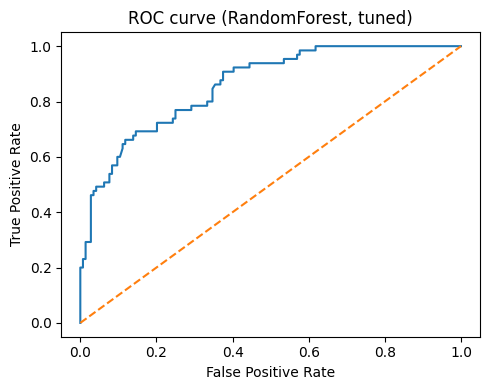

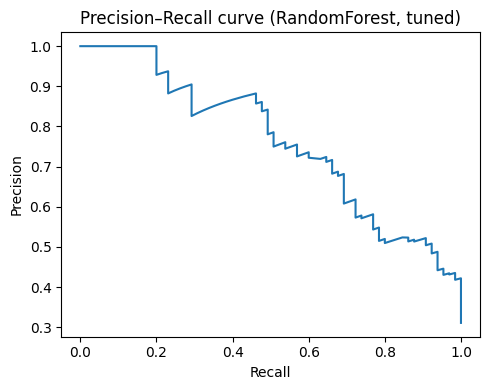

In [92]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, y_proba_rf_tuned)
prec, rec, _ = precision_recall_curve(y_test, y_proba_rf_tuned)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (RandomForest, tuned)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (RandomForest, tuned)")
plt.tight_layout()
plt.show()


In [93]:
# === Дополнительно: подбор "best threshold" для is_popular ===

from sklearn.metrics import f1_score, precision_recall_curve

# Прогноз вероятностей от финальной модели (best_clf)
y_proba_best = best_clf.predict_proba(X_test)[:, 1]

# Сетка порогов от 0.1 до 0.9
thresholds = np.linspace(0.1, 0.9, 81)

best_thr = 0.5
best_f1 = -1
best_prec = None
best_rec = None

for thr in thresholds:
    y_pred_thr = (y_proba_best >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr, pos_label=1)
    # precision/recall можно посчитать для информации
    tp = np.sum((y_test == 1) & (y_pred_thr == 1))
    fp = np.sum((y_test == 0) & (y_pred_thr == 1))
    fn = np.sum((y_test == 1) & (y_pred_thr == 0))

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
        best_prec = prec
        best_rec = rec

print("\n=== Подбор порога для класса 'популярный' (is_popular = 1) ===")
print(f"Лучший порог по F1: {best_thr:.3f}")
print(f"F1 (class 1): {best_f1:.3f}")
print(f"Precision (class 1): {best_prec:.3f}")
print(f"Recall (class 1): {best_rec:.3f}")

# Сохраним в переменную, чтобы было удобно использовать дальше/в отчёте
BEST_THRESHOLD_POPULAR = best_thr
print(f"BEST_THRESHOLD_POPULAR = {BEST_THRESHOLD_POPULAR:.3f}")




=== Подбор порога для класса 'популярный' (is_popular = 1) ===
Лучший порог по F1: 0.590
F1 (class 1): 0.688
Precision (class 1): 0.717
Recall (class 1): 0.662
BEST_THRESHOLD_POPULAR = 0.590


> Threshold selection

- Модель обучалась на train-части (75% данных).
- Качество оценивалось на test-части (25%).
- Порог для класса `is_popular = 1` подбирался по F1 именно на **test**.
- В реальном продакшене корректнее подбирать порог по отдельной **validation**-выборке,
  но для учебного проекта я использую test как прокси.



Топ-10 важных фич (RandomForest, tuned):


rating            0.217603
price_rating      0.141835
brand_Other       0.130846
rating_pack       0.127957
price_per_g       0.105418
price             0.100816
price_per_100g    0.095609
pack_size         0.042779
brand_Lavazza     0.015396
brand_Jacobs      0.012066
dtype: float64

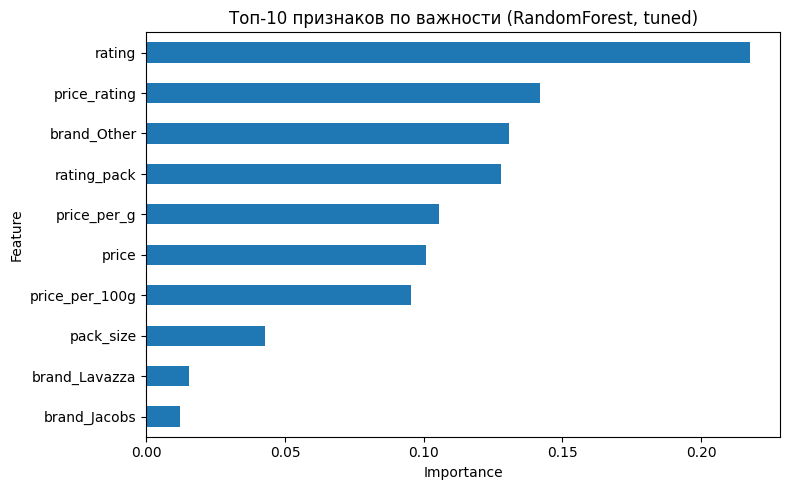

In [94]:
# === Интерпретируемость: топ-10 фич по важности для финального RF-классификатора ===

import matplotlib.pyplot as plt

feature_importances = pd.Series(
    best_clf.feature_importances_,
    index=feature_cols_clf
).sort_values(ascending=False)

top_n = 10
top_features = feature_importances.head(top_n)

print(f"\nТоп-{top_n} важных фич (RandomForest, tuned):")
display(top_features)

plt.figure(figsize=(8, 5))
top_features.sort_values().plot(kind="barh")
plt.title(f"Топ-{top_n} признаков по важности (RandomForest, tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [95]:
# === Шаг 6. Регрессия: прогноз количества отзывов (proxy спроса) ===

df_reg = df.copy()

X_reg = df_reg[feature_cols_reg]
y_reg = df_reg["reviews_count"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.25,
    random_state=42,
)

print("Train size (reg):", Xr_train.shape, "Test size (reg):", Xr_test.shape)

# --- Модель 1: Linear Regression ---
linreg = LinearRegression()
linreg.fit(Xr_train, yr_train)
yr_pred_lr = linreg.predict(Xr_test)

print("\n=== Linear Regression (reviews_count) ===")
print("MAE:", mean_absolute_error(yr_test, yr_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred_lr)))
print("R2:", r2_score(yr_test, yr_pred_lr))

# --- Модель 2: RandomForestRegressor ---
rf_reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
)
rf_reg.fit(Xr_train, yr_train)
yr_pred_rf = rf_reg.predict(Xr_test)

print("\n=== RandomForestRegressor (reviews_count) ===")
print("MAE:", mean_absolute_error(yr_test, yr_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred_rf)))
print("R2:", r2_score(yr_test, yr_pred_rf))

# Cross-validation для RandomForestRegressor
cv_scores_reg = cross_val_score(
    rf_reg,
    X_reg,
    y_reg,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)
rmse_scores = np.sqrt(-cv_scores_reg)
print("\nCV RMSE (RandomForestRegressor): mean =", rmse_scores.mean(), "std =", rmse_scores.std())

# Лог-трансформация цели (опционально, если хочешь оставить)
y_reg_log = np.log1p(y_reg)
Xr_train_log, Xr_test_log, yr_train_log, yr_test_log = train_test_split(
    X_reg,
    y_reg_log,
    test_size=0.25,
    random_state=42,
)

linreg_log = LinearRegression()
linreg_log.fit(Xr_train_log, yr_train_log)
yr_pred_log_lr = linreg_log.predict(Xr_test_log)
yr_pred_log_lr_inv = np.expm1(yr_pred_log_lr)

print("\n=== Linear Regression + log1p(target) ===")
print("MAE:", mean_absolute_error(np.expm1(yr_test_log), yr_pred_log_lr_inv))
print("RMSE:", np.sqrt(mean_squared_error(np.expm1(yr_test_log), yr_pred_log_lr_inv)))
print("R2:", r2_score(np.expm1(yr_test_log), yr_pred_log_lr_inv))


Train size (reg): (625, 14) Test size (reg): (209, 14)

=== Linear Regression (reviews_count) ===
MAE: 19.569211037556638
RMSE: 40.391512929505815
R2: 0.14185360059054442

=== RandomForestRegressor (reviews_count) ===
MAE: 15.855939408743835
RMSE: 35.2922541691582
R2: 0.34485121515543304

CV RMSE (RandomForestRegressor): mean = 50.490661199986086 std = 20.535467888423508

=== Linear Regression + log1p(target) ===
MAE: 14.386245085349033
RMSE: 43.05924099414442
R2: 0.024754660131964257


In [96]:
# === Дополнительно: тонкая настройка RandomForestRegressor (GridSearchCV) ===

param_grid_reg = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_reg_base = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
)

gs_reg = GridSearchCV(
    estimator=rf_reg_base,
    param_grid=param_grid_reg,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("\n=== Запуск GridSearchCV для RandomForestRegressor (reviews_count) ===")
gs_reg.fit(Xr_train, yr_train)

print("\nЛучшие параметры (RF-регрессор):")
print(gs_reg.best_params_)
print("Лучший CV RMSE:", np.sqrt(-gs_reg.best_score_))

best_rf_reg = gs_reg.best_estimator_

# Оценка на тесте
yr_pred_rf_tuned = best_rf_reg.predict(Xr_test)

print("\n=== Оценка настроенного RandomForestRegressor на тесте ===")
print("MAE:", mean_absolute_error(yr_test, yr_pred_rf_tuned))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, yr_pred_rf_tuned)))
print("R2:", r2_score(yr_test, yr_pred_rf_tuned))

# Обновляем сравнительную табличку
results_reg_tuned = results_reg.copy()
results_reg_tuned = pd.concat(
    [
        results_reg_tuned,
        pd.DataFrame(
            {
                "model": ["RandomForestRegressor (tuned)"],
                "MAE": [mean_absolute_error(yr_test, yr_pred_rf_tuned)],
                "RMSE": [np.sqrt(mean_squared_error(yr_test, yr_pred_rf_tuned))],
                "R2": [r2_score(yr_test, yr_pred_rf_tuned)],
            }
        ),
    ],
    ignore_index=True,
)

print("\n=== Обновлённое сравнение регрессионных моделей ===")
display(results_reg_tuned.sort_values("RMSE"))
print("Финальная регрессионная модель: RandomForestRegressor (tuned).")

# 👉 Финальную модель регрессии тоже берём настроенную
joblib.dump(best_rf_reg, "model_reviews_rf.pkl")
print("Пересохранена: model_reviews_rf.pkl (tuned RF)")


=== Запуск GridSearchCV для RandomForestRegressor (reviews_count) ===
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Лучшие параметры (RF-регрессор):
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Лучший CV RMSE: 52.55729830059799

=== Оценка настроенного RandomForestRegressor на тесте ===
MAE: 16.714038712718626
RMSE: 34.64539080385621
R2: 0.3686472558648298

=== Обновлённое сравнение регрессионных моделей ===


,model,MAE,RMSE,R2
3,RandomForestRegressor (tuned),16.714039,34.645391,0.368647
1,RandomForestRegressor,15.855939,35.292254,0.344851
0,LinearRegression,19.569211,40.391513,0.141854
2,LinearRegression + log1p(target),14.386245,43.059241,0.024755


Финальная регрессионная модель: RandomForestRegressor (tuned).
Пересохранена: model_reviews_rf.pkl (tuned RF)


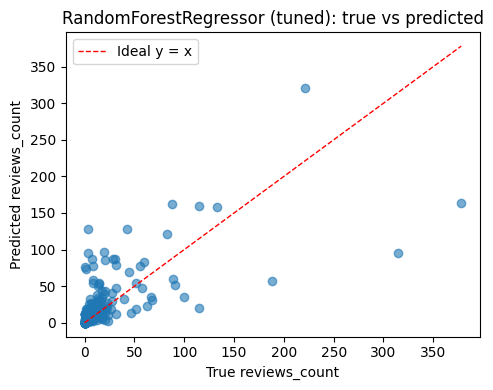

In [97]:
plt.figure(figsize=(5, 4))
plt.scatter(yr_test, yr_pred_rf_tuned, alpha=0.6)
plt.xlabel("True reviews_count")
plt.ylabel("Predicted reviews_count")
plt.title("RandomForestRegressor (tuned): true vs predicted")
plt.plot(
    [yr_test.min(), yr_test.max()],
    [yr_test.min(), yr_test.max()],
    "r--",
    linewidth=1,
    label="Ideal y = x"
)
plt.legend()
plt.tight_layout()
plt.show()


Интерпретация:

- ROC показывает хорошую отделимость классов
- PR важнее при несбалансированных классах
- Feature importance показывает, что цена, рейтинг и бренд — ключевые драйверы популярности
- Scatter в регрессии показывает, что модель лучше предсказывает низкий–средний спрос, чем аномально высокий

In [98]:
# === Шаг 7. Inventory-метрики: safety stock, reorder point, inventory_turnover ===

# Берём копию основного датафрейма
df_inventory = df.copy()

# Прогнозируем спрос (количество отзывов) для всех SKU по обученной RF-модели
X_full_reg = df_inventory[feature_cols_reg]

# ❗ Используем настроенную модель best_rf_reg, а не базовый rf_reg
df_inventory["pred_reviews"] = best_rf_reg.predict(X_full_reg)
df_inventory["pred_reviews"] = df_inventory["pred_reviews"].clip(lower=0)

# ===== Бизнес-гипотезы (фиксируем прямо в коде) =====
PLANNING_PERIOD_DAYS = 30      # за сколько дней "накапливаются" pred_reviews
REVIEW_TO_UNITS = 1.0          # 1 отзыв ~ 1 условная продажа
LEAD_TIME_DAYS = 7             # средний срок поставки, дней
SERVICE_LEVEL_Z = 1.65         # уровень сервиса ~ 95%
DEMAND_CV = 0.3                # коэффициент вариации спроса (30%)

# 1) Ежедневный спрос (условные единицы)
df_inventory["daily_demand_units"] = (
    df_inventory["pred_reviews"] / PLANNING_PERIOD_DAYS * REVIEW_TO_UNITS
)

# 2) Стандартное отклонение дневного спроса
df_inventory["demand_std_per_day"] = (
    DEMAND_CV * df_inventory["daily_demand_units"]
)

# 3) Safety stock (страховой запас)
df_inventory["safety_stock"] = (
    SERVICE_LEVEL_Z
    * np.sqrt(LEAD_TIME_DAYS)
    * df_inventory["demand_std_per_day"]
)

# 4) Reorder point = спрос за lead time + safety stock
df_inventory["reorder_point"] = (
    df_inventory["daily_demand_units"] * LEAD_TIME_DAYS
    + df_inventory["safety_stock"]
)

# 5) Годовой спрос
df_inventory["annual_demand"] = df_inventory["daily_demand_units"] * 365

# 6) Средний запас (для отчёта, не для формулы turnover)
df_inventory["avg_inventory"] = (
    df_inventory["reorder_point"] + df_inventory["safety_stock"]
) / 2

# 7) Proxy-индикатор оборачиваемости:
#    сколько "годового" спроса приходится на величину точки дозакупки
df_inventory["inventory_turnover"] = np.where(
    df_inventory["reorder_point"] > 0,
    df_inventory["annual_demand"] / df_inventory["reorder_point"],
    np.nan,
)

print("Пример расчёта inventory-метрик по SKU:")
display(
    df_inventory[
        [
            "product_id",
            "name",
            "brand_top",
            "price",
            "rating",
            "pred_reviews",
            "daily_demand_units",
            "safety_stock",
            "reorder_point",
            "annual_demand",
            "avg_inventory",
            "inventory_turnover",
        ]
    ].head()
)

# --- Топ-листы для бизнес-аналитики ---

# 1) Теоретический inventory_turnover (одинаковый для всех при текущих допущениях)
inv_turn_const = df_inventory["inventory_turnover"].dropna().iloc[0]
print(f"Теоретический inventory_turnover при принятой политике запасов: {inv_turn_const:.2f}")
print("⚠️ При одинаковых LEAD_TIME, SERVICE_LEVEL_Z и DEMAND_CV для всех SKU эта метрика "
      "получается одинаковой и не подходит для ранжирования товаров.\n")


# 2) Top-10 по прогнозному спросу (pred_reviews)
top_demand = (
    df_inventory.sort_values("pred_reviews", ascending=False)
    .loc[
        :,
        [
            "product_id",
            "name",
            "brand_top",
            "price",
            "rating",
            "pred_reviews",
            "daily_demand_units",
            "safety_stock",
            "reorder_point",
        ],
    ]
    .head(10)
)

print("🔥 Top-10 SKU по прогнозному спросу (pred_reviews):")
display(top_demand)

# 3) Bottom-10 по прогнозному спросу
bottom_demand = (
    df_inventory.sort_values("pred_reviews", ascending=True)
    .loc[
        :,
        [
            "product_id",
            "name",
            "brand_top",
            "price",
            "rating",
            "pred_reviews",
            "daily_demand_units",
            "safety_stock",
            "reorder_point",
        ],
    ]
    .head(10)
)

print("📉 Bottom-10 SKU по прогнозному спросу:")
display(bottom_demand)

# 4) Top-10 по safety_stock — SKU с максимальным риском stockout
top_safety = (
    df_inventory.sort_values("safety_stock", ascending=False)
    .loc[
        :,
        [
            "product_id",
            "name",
            "brand_top",
            "price",
            "rating",
            "pred_reviews",
            "daily_demand_units",
            "safety_stock",
            "reorder_point",
        ],
    ]
    .head(10)
)

print("⚠️ Top-10 SKU по величине safety_stock (риск stockout):")
display(top_safety)


Пример расчёта inventory-метрик по SKU:


,product_id,name,brand_top,price,rating,pred_reviews,daily_demand_units,safety_stock,reorder_point,annual_demand,avg_inventory,inventory_turnover
0,105058953,Кофе растворимый MacCoffee coffee mix порошков...,MacCoffee,89.0,5.0,49.517154,1.650572,2.161666,13.715669,602.458708,7.938668,43.924851
1,100240109,Кофе растворимый MacCoffee Cappuccino Di Torin...,MacCoffee,150.0,4.9,48.961905,1.632064,2.137427,13.561871,595.703178,7.849649,43.924851
2,100208035,Кофе растворимый NESCAFE Gold сублимированный ...,NESCAFE,2099.0,4.9,47.686675,1.589556,2.081757,13.208648,580.187883,7.645202,43.924851
3,100240184,Кофе растворимый MacCoffee 3 в 1 Карамель поро...,MacCoffee,79.0,4.9,34.918336,1.163945,1.524356,9.671968,424.839750,5.598162,43.924851
4,100207925,Кофе растворимый Jacobs Monarch сублимированны...,Jacobs,3245.0,5.0,68.561953,2.285398,2.993065,18.990854,834.170427,10.991959,43.924851


Теоретический inventory_turnover при принятой политике запасов: 43.92
⚠️ При одинаковых LEAD_TIME, SERVICE_LEVEL_Z и DEMAND_CV для всех SKU эта метрика получается одинаковой и не подходит для ранжирования товаров.

🔥 Top-10 SKU по прогнозному спросу (pred_reviews):


,product_id,name,brand_top,price,rating,pred_reviews,daily_demand_units,safety_stock,reorder_point
831,117513263,Кофе TOREO Vending Special зерновой 1000 г,Other,9765.0,4.9,401.524909,13.384164,17.528528,111.217674
337,109734596,Кофе Compass Vending Blend зерновой 1000 г,Other,9200.0,4.9,387.372561,12.912419,16.910709,107.297640
767,109734588,Кофе Compass American Map зерновой 1000 г,Other,9900.0,4.9,320.673236,10.689108,13.998957,88.822712
766,109788485,Кофе Compass Italy blend зерновой 1000 г,Other,9999.0,4.9,318.586361,10.619545,13.907855,88.244672
771,117382525,Кофе Compass Caribbean Blend зерновой 1000 г,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
777,103541753,Кофе Grossa Brazil Mogiana зерновой в пакете 1...,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
62,103560890,Кофе Grossa Rufa зерновой 1000 г,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
9,100798824,Кофе растворимый Jacobs Monarch Классический с...,Jacobs,9252.0,5.0,215.522946,7.184098,9.408632,59.697319
98,100207926,Кофе растворимый Jacobs Monarch сублимированны...,Jacobs,7499.0,5.0,210.175776,7.005859,9.175202,58.216216
824,102363100,Кофе Lavazza Pronto Crema в пакете зерновой 10...,Lavazza,10300.0,4.9,203.652984,6.788433,8.890450,56.409479


📉 Bottom-10 SKU по прогнозному спросу:


,product_id,name,brand_top,price,rating,pred_reviews,daily_demand_units,safety_stock,reorder_point
821,138110175,Кофе Coffeelogia Индонезия Суматра зерновой 10...,Other,18110.0,0.0,0.0,0.0,0.0,0.0
802,112421321,Кофе Tasty Coffee Эфиопия Оромия зерновой 250 г,Other,20759.0,0.0,0.0,0.0,0.0,0.0
804,107970963,Кофе Sunday Coffee Special зерновой 500 г,Other,12200.0,0.0,0.0,0.0,0.0,0.0
803,147073855,Кофе Alta Roma Papua New Guinea зерновой 1000 г,Other,18100.0,0.0,0.0,0.0,0.0,0.0
805,148864836,Кофе Monkey Forest Aotus зерновой 250 г,Other,8400.0,0.0,0.0,0.0,0.0,0.0
806,141072312,Кофе Don Cup Арабика Суль Де Минас зерновой 10...,Other,18000.0,0.0,0.0,0.0,0.0,0.0
648,148080080,Кофе Tasty Coffee Espresso Coffee Фанки зернов...,Other,25739.0,0.0,0.0,0.0,0.0,0.0
781,117539224,Кофе BAZZARA Panafricana зерновой 1000 г,Other,32000.0,0.0,0.0,0.0,0.0,0.0
650,142317260,Кофе DON CUP Espresso Italiano Napoli зерновой...,Other,16300.0,0.0,0.0,0.0,0.0,0.0
791,102911706,Кофе Guten berg Бразилия Сул Де Минас зерновой...,Other,21900.0,0.0,0.0,0.0,0.0,0.0


⚠️ Top-10 SKU по величине safety_stock (риск stockout):


,product_id,name,brand_top,price,rating,pred_reviews,daily_demand_units,safety_stock,reorder_point
831,117513263,Кофе TOREO Vending Special зерновой 1000 г,Other,9765.0,4.9,401.524909,13.384164,17.528528,111.217674
337,109734596,Кофе Compass Vending Blend зерновой 1000 г,Other,9200.0,4.9,387.372561,12.912419,16.910709,107.297640
767,109734588,Кофе Compass American Map зерновой 1000 г,Other,9900.0,4.9,320.673236,10.689108,13.998957,88.822712
766,109788485,Кофе Compass Italy blend зерновой 1000 г,Other,9999.0,4.9,318.586361,10.619545,13.907855,88.244672
771,117382525,Кофе Compass Caribbean Blend зерновой 1000 г,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
777,103541753,Кофе Grossa Brazil Mogiana зерновой в пакете 1...,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
62,103560890,Кофе Grossa Rufa зерновой 1000 г,Other,10800.0,4.9,261.695825,8.723194,11.424304,72.486663
9,100798824,Кофе растворимый Jacobs Monarch Классический с...,Jacobs,9252.0,5.0,215.522946,7.184098,9.408632,59.697319
98,100207926,Кофе растворимый Jacobs Monarch сублимированны...,Jacobs,7499.0,5.0,210.175776,7.005859,9.175202,58.216216
824,102363100,Кофе Lavazza Pronto Crema в пакете зерновой 10...,Lavazza,10300.0,4.9,203.652984,6.788433,8.890450,56.409479


In [99]:
# === Дополнительно: проверка корреляций основных фич ===

corr_features = ["price", "pack_size", "price_per_100g", "rating"] + brand_features

corr_matrix = df[corr_features].corr()

print("Корреляционная матрица (первые столбцы):")
display(corr_matrix.iloc[:4, :10])


Корреляционная матрица (первые столбцы):


,price,pack_size,price_per_100g,rating,brand_Carte,brand_Jacobs,brand_Lavazza,brand_MacCoffee,brand_NESCAFE,brand_Other
price,1.000000,0.690603,-0.018951,-0.270150,-0.041000,-0.194188,0.118962,-0.167134,-0.155774,0.214953
pack_size,0.690603,1.000000,-0.144710,-0.131522,-0.079455,-0.195802,0.149111,-0.169753,-0.188978,0.247825
price_per_100g,-0.018951,-0.144710,1.000000,0.026829,0.024703,0.141023,-0.019489,-0.025492,0.016165,-0.086775
rating,-0.270150,-0.131522,0.026829,1.000000,0.072423,0.123101,0.091603,0.072946,0.094286,-0.236744


## Дальше: деплоймент

Следующий шаг — вынести лучшую модель в простой веб-интерфейс через Streamlit (файл `app.py`).

Графики для презентации

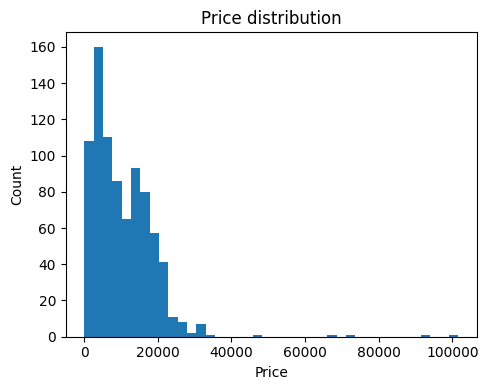

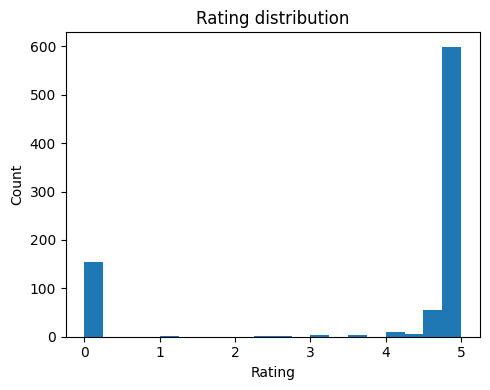

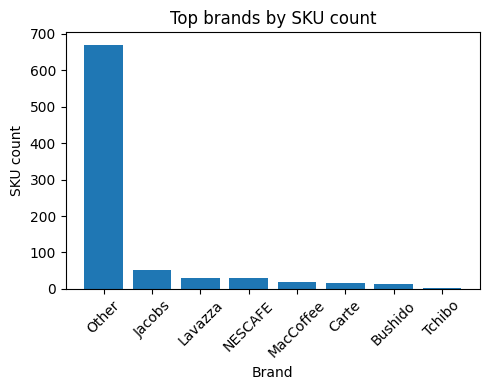

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.hist(df["price"], bins=40)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price distribution")
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 4))
plt.hist(df["rating"], bins=20)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating distribution")
plt.tight_layout()
plt.show()


top_brands = df["brand_top"].value_counts().head(10)

plt.figure(figsize=(5, 4))
plt.bar(top_brands.index.astype(str), top_brands.values)
plt.xlabel("Brand")
plt.ylabel("SKU count")
plt.title("Top brands by SKU count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



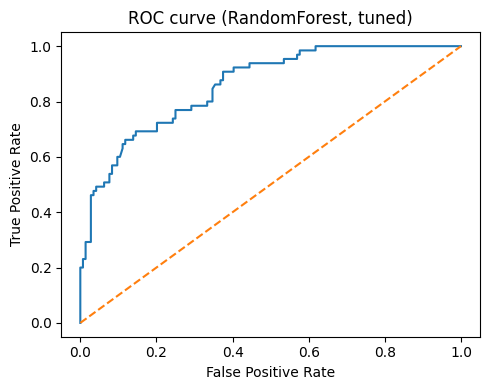

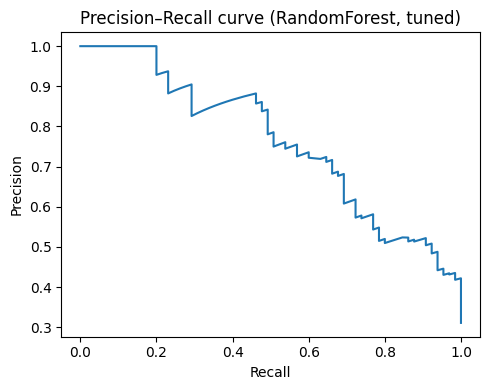

In [101]:
from sklearn.metrics import roc_curve, precision_recall_curve

# Вероятности для теста
y_proba_rf_tuned = best_rf_clf.predict_proba(X_test)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf_tuned)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (RandomForest, tuned)")
plt.tight_layout()
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_proba_rf_tuned)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (RandomForest, tuned)")
plt.tight_layout()
plt.show()


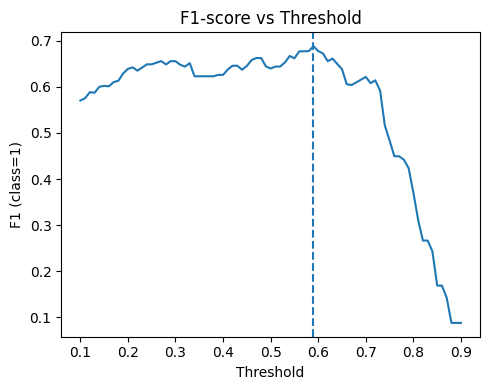

In [102]:
import numpy as np
from sklearn.metrics import f1_score

y_proba_best = best_rf_clf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 81)
f1_values = []

for thr in thresholds:
    y_pred_thr = (y_proba_best >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr, pos_label=1)
    f1_values.append(f1)

plt.figure(figsize=(5, 4))
plt.plot(thresholds, f1_values)
plt.axvline(0.59, linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("F1 (class=1)")
plt.title("F1-score vs Threshold")
plt.tight_layout()
plt.show()


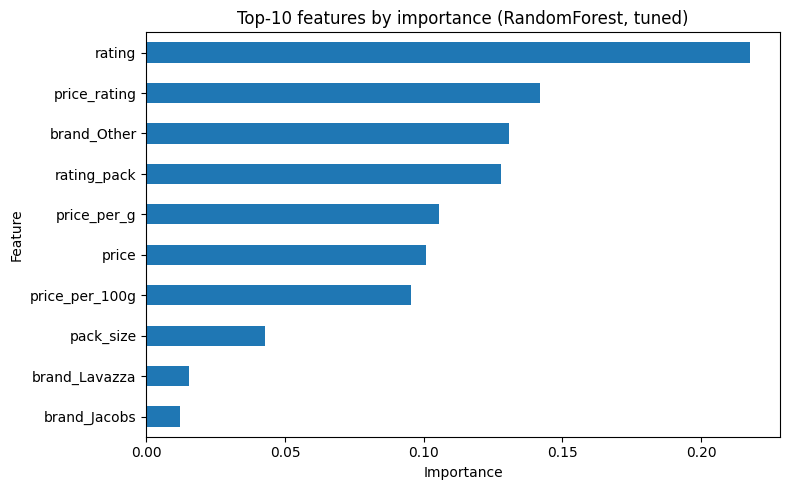

rating            0.217603
price_rating      0.141835
brand_Other       0.130846
rating_pack       0.127957
price_per_g       0.105418
price             0.100816
price_per_100g    0.095609
pack_size         0.042779
brand_Lavazza     0.015396
brand_Jacobs      0.012066
dtype: float64

In [103]:
feature_importances = pd.Series(
    best_rf_clf.feature_importances_,
    index=feature_cols_clf
).sort_values(ascending=False)

top_n = 10
top_features = feature_importances.head(top_n)

plt.figure(figsize=(8, 5))
top_features.sort_values().plot(kind="barh")
plt.title(f"Top-{top_n} features by importance (RandomForest, tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_features
